In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tweets = pd.read_csv("twitter_sentiments_16_au_21_avril.csv")

In [3]:
tweets["count_pos"] = tweets["count"]*tweets["pos"]

In [4]:
tweets = tweets.groupby("candidat").sum()["count_pos"].reset_index()

In [5]:
tweets["bloc"] = tweets["candidat"].map(lambda x : "gauche" if x in ["arthaud", "poutou", "macron", "hamon", "melenchon"] else x)

In [6]:
tweets["bloc"] = tweets["bloc"].map(lambda x : "droite" if x in ["cheminade", "fillon", "nda", "lassalle", "asselineau"] else x)

In [7]:
print(tweets)

      candidat  count_pos    bloc
0      arthaud       40.0  gauche
1   asselineau       49.0  droite
2    cheminade        5.0  droite
3       fillon    10208.0  droite
4        hamon     2861.0  gauche
5     lassalle        2.0  droite
6       le pen     2903.0  le pen
7       macron     8611.0  gauche
8    melenchon     3974.0  gauche
9          nda      906.0  droite
10      poutou     1188.0  gauche


In [8]:
sum_blocs = tweets.groupby("bloc").sum().reset_index()
tweets = tweets.merge(sum_blocs, how="left", on="bloc")

In [9]:
tweets

,candidat,count_pos_x,bloc,count_pos_y
0,arthaud,40.0,gauche,16674.0
1,asselineau,49.0,droite,11170.0
2,cheminade,5.0,droite,11170.0
3,fillon,10208.0,droite,11170.0
4,hamon,2861.0,gauche,16674.0
5,lassalle,2.0,droite,11170.0
6,le pen,2903.0,le pen,2903.0
7,macron,8611.0,gauche,16674.0
8,melenchon,3974.0,gauche,16674.0
9,nda,906.0,droite,11170.0


In [10]:
tweets["%pos"] = tweets["count_pos_x"]*100/tweets["count_pos_y"]

In [11]:
print(tweets)

      candidat  count_pos_x    bloc  count_pos_y        %pos
0      arthaud         40.0  gauche      16674.0    0.239894
1   asselineau         49.0  droite      11170.0    0.438675
2    cheminade          5.0  droite      11170.0    0.044763
3       fillon      10208.0  droite      11170.0   91.387645
4        hamon       2861.0  gauche      16674.0   17.158450
5     lassalle          2.0  droite      11170.0    0.017905
6       le pen       2903.0  le pen       2903.0  100.000000
7       macron       8611.0  gauche      16674.0   51.643277
8    melenchon       3974.0  gauche      16674.0   23.833513
9          nda        906.0  droite      11170.0    8.111012
10      poutou       1188.0  gauche      16674.0    7.124865


In [12]:
tweets["pred_blocs"] = [40.25, 25.96, 25.96, 25.96, 40.25, 25.96, 23.46, 40.25, 40.25, 25.96, 40.25]
tweets["pred_pond_twitter"] = tweets["%pos"]*tweets["pred_blocs"]/100
tweets["transferts_bayrou_%"] = [0.67, 0.33, 0, 19, 5.67, 2, 3, 49.67, 13.67, 4.33, 1.67]
tweets["pred_pond_twitter"] = tweets["pred_pond_twitter"]+10.31*tweets["transferts_bayrou_%"]/100

In [13]:
tweets[["candidat", "pred_pond_twitter"]]

,candidat,pred_pond_twitter
0,arthaud,0.165635
1,asselineau,0.147903
2,cheminade,0.011620
3,fillon,25.683133
4,hamon,7.490853
5,lassalle,0.210848
6,le pen,23.769300
7,macron,25.907396
8,melenchon,11.002366
9,nda,2.552042


In [14]:
google = pd.read_excel("google_trends_15_au_20.xlsx")

In [15]:
google = google.mean().reset_index()

In [16]:
google["index"] = google["index"].map(lambda x : " ".join(x.split()[1:]).lower().replace("dupont-aignan", "nda").replace("é", "e"))

In [17]:
tweets = tweets.merge(google, how="left", left_on="candidat", right_on="index")
tweets.drop("index", axis=1, inplace=True)

In [18]:
tweets.rename(columns={0:"recherches_google"}, inplace=True)

In [19]:
google_bloc = tweets.groupby("bloc").sum()["recherches_google"].reset_index()
tweets = tweets.merge(google_bloc, how="left", on="bloc")

In [20]:
tweets["pred_pond_google"] = tweets["pred_blocs"]*tweets["recherches_google_x"]*100/tweets["recherches_google_y"]/100

In [21]:
tweets["pred_pond_google"] = tweets["pred_pond_google"]+10.31*tweets["transferts_bayrou_%"]/100


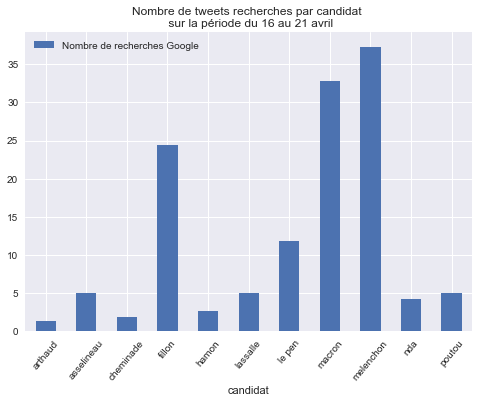

In [40]:
pos_tweets = tweets[["candidat", "recherches_google_x"]].set_index("candidat").rename(columns={"recherches_google_x":"Nombre de recherches Google"})
ax = pos_tweets.plot.bar()
ax.set_title("Nombre de tweets recherches par candidat \n sur la période du 16 au 21 avril")
ax.set_xticklabels(pos_tweets.index, rotation=50)
plt.show()

In [23]:
tweets["pred_pond_sondages"] = [0.36, 0.87, 0.24, 21.99, 6.41, 1.17, 23.77, 23.43, 15.86, 4.57, 1.32]

In [24]:
final_pred = tweets[["candidat", "pred_pond_google", "pred_pond_twitter", "pred_pond_sondages"]]


In [25]:
final_pred["mean_pred"] = final_pred.mean(axis=1)

C:\Users\Mohamed\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
final_pred.rename(columns={"pred_pond_google":"prédiction Google", \
                           "pred_pond_twitter":"prédiction Twitter", \
                          "pred_pond_sondages":"prédiction sondages",\
                          "mean_pred": "moyenne des trois"}, inplace=True)
final_pred = final_pred.set_index("candidat")


C:\Users\Mohamed\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


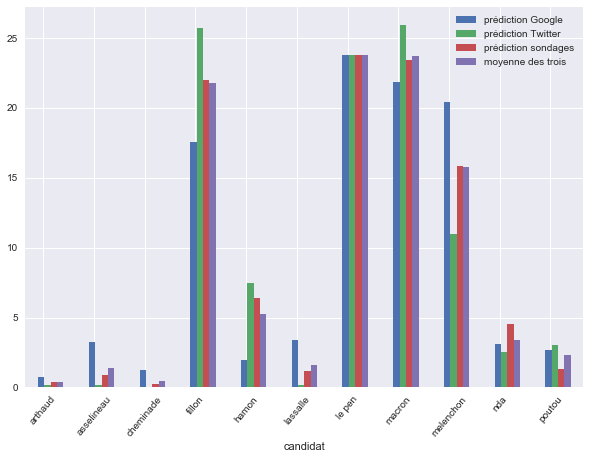

In [27]:
ax = final_pred.plot.bar(figsize=[10,7], position=0.2)
ax.set_xticklabels(final_pred.index, rotation=50)
plt.show()

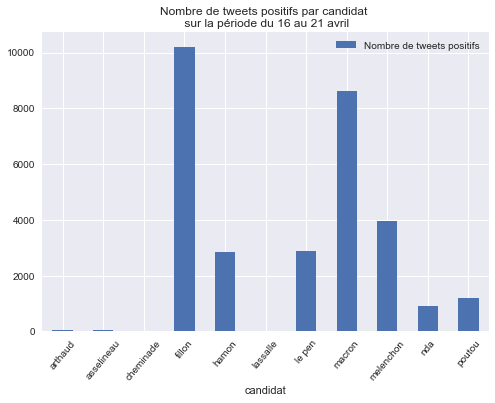

In [41]:
pos_tweets = tweets[["candidat", "count_pos_x"]].set_index("candidat").rename(columns={"count_pos_x":"Nombre de tweets positifs"})
ax = pos_tweets.plot.bar()
ax.set_title("Nombre de tweets positifs par candidat \n sur la période du 16 au 21 avril")
ax.set_xticklabels(pos_tweets.index, rotation=50)
plt.show()

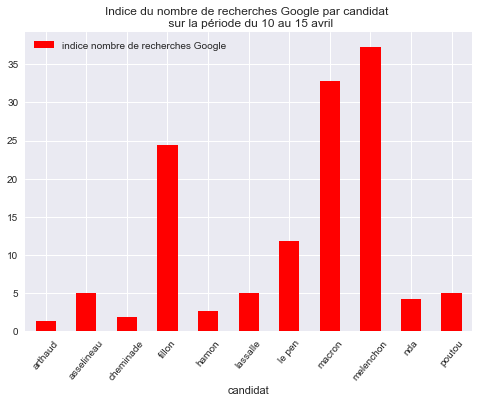

In [29]:
recherches_google = tweets[["candidat", "recherches_google_x"]].set_index("candidat").rename(columns={"recherches_google_x":"indice nombre de recherches Google"})
ax = recherches_google.plot.bar(color="red")
ax.set_xticklabels(recherches_google.index, rotation=50)
ax.set_title("Indice du nombre de recherches Google par candidat \n sur la période du 10 au 15 avril")
plt.show()

In [30]:
ponderations_twitter = tweets["%pos"]
tweets["%google"] = tweets["recherches_google_x"]*100/tweets["recherches_google_y"]

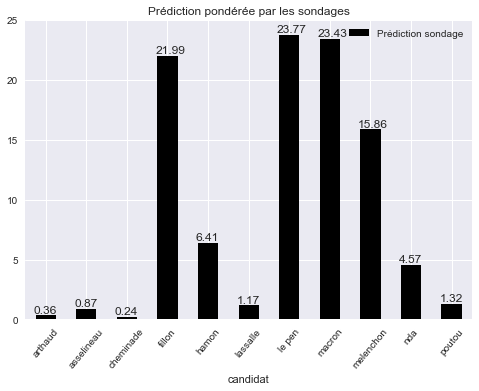

In [31]:
sondages_pred = tweets[["candidat", "pred_pond_sondages"]].set_index("candidat").rename(columns={"pred_pond_sondages":"Prédiction sondage"})
ax = sondages_pred.plot.bar(color="black", grid=True)
ax.set_xticklabels(recherches_google.index, rotation=50)

for i, label in enumerate(list(sondages_pred.index)):
    score = sondages_pred.ix[label]["Prédiction sondage"]
    ax.annotate(str(score), (i-0.3, score + 0.2))
ax.set_title("Prédiction pondérée par les sondages")
plt.show()

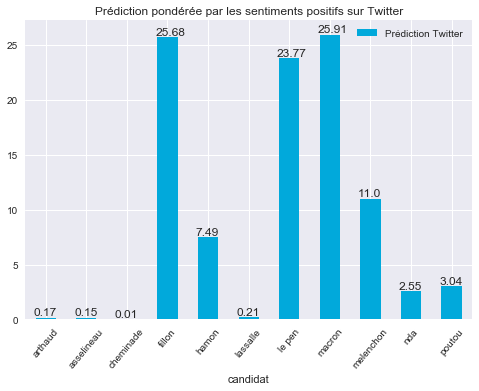

In [32]:
sondages_pred = np.round(tweets[["candidat", "pred_pond_twitter"]].set_index("candidat").rename(columns={"pred_pond_twitter":"Prédiction Twitter"}),2)
ax = sondages_pred.plot.bar(color="#01A9DB", grid=True)
ax.set_xticklabels(recherches_google.index, rotation=50)

for i, label in enumerate(list(sondages_pred.index)):
    score = sondages_pred.ix[label]["Prédiction Twitter"]
    ax.annotate(str(score), (i-0.3, score + 0.2))
ax.set_title("Prédiction pondérée par les sentiments positifs sur Twitter")
plt.show()

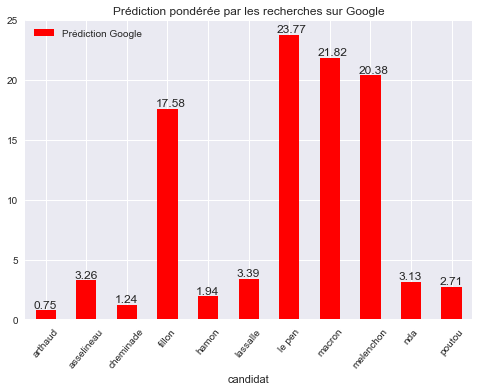

In [33]:
sondages_pred = np.round(tweets[["candidat", "pred_pond_google"]].set_index("candidat").rename(columns={"pred_pond_google":"Prédiction Google"}),2)
ax = sondages_pred.plot.bar(color="red", grid=True)
ax.set_xticklabels(recherches_google.index, rotation=50)

for i, label in enumerate(list(sondages_pred.index)):
    score = sondages_pred.ix[label]["Prédiction Google"]
    ax.annotate(str(score), (i-0.3, score + 0.2))
ax.set_title("Prédiction pondérée par les recherches sur Google")
plt.legend(loc=2)
plt.show()

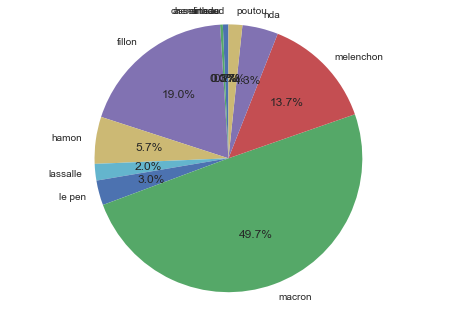

In [34]:
fig1, ax1 = plt.subplots()
ax1.pie(tweets["transferts_bayrou_%"], labels=tweets["candidat"], autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

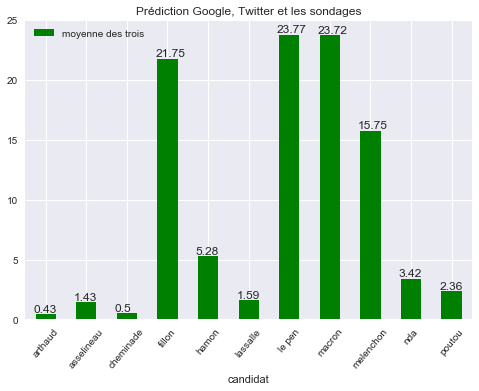

In [35]:
sondages_pred = np.round(final_pred.reset_index()[["candidat", "moyenne des trois"]].set_index("candidat"),2)
ax = sondages_pred.plot.bar(color="green", grid=True)
ax.set_xticklabels(recherches_google.index, rotation=50)

for i, label in enumerate(list(sondages_pred.index)):
    score = sondages_pred.ix[label]["moyenne des trois"]
    ax.annotate(str(score), (i-0.3, score + 0.2))
ax.set_title("Prédiction Google, Twitter et les sondages")
plt.legend(loc=2)
plt.show()


In [36]:
tweets["sondages"] = [0.94, 4, 0.62, 77.67, 15.1, 4.32, 100, 43.88, 36.38, 14.01, 3.12]

In [37]:
tweets[["candidat", "sondages", "%pos", "%google"]].set_index("candidat").mean(axis=1)

candidat
arthaud         0.958378
asselineau      5.624475
cheminade       1.818654
fillon         76.405991
hamon          11.876592
lassalle        5.534957
le pen        100.000000
macron         45.671185
melenchon      35.781671
nda            10.822589
poutou          5.518840
dtype: float64

In [38]:
tweets

,candidat,count_pos_x,bloc,count_pos_y,%pos,pred_blocs,pred_pond_twitter,transferts_bayrou_%,recherches_google_x,recherches_google_y,pred_pond_google,pred_pond_sondages,%google,sondages
0,arthaud,40.0,gauche,16674.0,0.239894,40.25,0.165635,0.67,1.340909,79.098485,0.751411,0.36,1.695240,0.94
1,asselineau,49.0,droite,11170.0,0.438675,25.96,0.147903,0.33,5.053030,40.636364,3.262084,0.87,12.434750,4.00
2,cheminade,5.0,droite,11170.0,0.044763,25.96,0.011620,0.00,1.946970,40.636364,1.243796,0.24,4.791201,0.62
3,fillon,10208.0,droite,11170.0,91.387645,25.96,25.683133,19.00,24.446970,40.636364,17.576521,21.99,60.160328,77.67
4,hamon,2861.0,gauche,16674.0,17.158450,40.25,7.490853,5.67,2.666667,79.098485,1.941535,6.41,3.371325,15.10
5,lassalle,2.0,droite,11170.0,0.017905,25.96,0.210848,2.00,4.984848,40.636364,3.390704,1.17,12.266965,4.32
6,le pen,2903.0,le pen,2903.0,100.000000,23.46,23.769300,3.00,11.909091,11.909091,23.769300,23.77,100.000000,100.00
7,macron,8611.0,gauche,16674.0,51.643277,40.25,25.907396,49.67,32.818182,79.098485,21.820814,23.43,41.490279,43.88
8,melenchon,3974.0,gauche,16674.0,23.833513,40.25,11.002366,13.67,37.280303,79.098485,20.379806,15.86,47.131501,36.38
9,nda,906.0,droite,11170.0,8.111012,25.96,2.552042,4.33,4.204545,40.636364,3.132441,4.57,10.346756,14.01
